# Question Tag Prediction 

Using the data from [Stack Overflow questions](https://www.kaggle.com/stackoverflow/stacksample), i Have created a DL model that predicts the associated tag based on the question

### Importing header files

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.probability import FreqDist


from collections import Counter 
from gensim.models import Word2Vec 
from operator import itemgetter 
from heapq import nsmallest 


from sklearn.preprocessing import LabelEncoder

from keras import backend as K 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical 


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
C:\Users\nnair\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nnair\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nnair\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\nnair\miniconda3\lib\site-packages\tensorflow\python\framework\dtype

### Reading the file

In [2]:
questions= pd.read_csv('data/Questions.csv', encoding='iso-8859-1')
tags=pd.read_csv('data/Tags.csv', encoding='iso-8859-1')

### Combining Tags(Based on Id)

In [3]:
tags['Tag'] = tags['Tag'].astype(str)

grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

grouped_tags.reset_index()
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [4]:
grouped_tags_final

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


----------------------------------------

## CLEANING DATA

### Dropping unnecessary columns and merging with tags

In [5]:
questions.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)
questions = questions.merge(grouped_tags_final, on='Id')


### Removing duplicates and filtering

In [6]:
new_df = questions[questions['Score']>5]

print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


### Selecting top 100 tags

In [7]:
# Finding the top 100 tags

new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]
my_set = set(all_tags)
unique_tags = list(my_set)


flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)
# keywords1 = nltk.FreqDist(keywords)
frequencies_words = keywords.most_common(100)

tags_features = [word[0] for word in frequencies_words]


In [8]:
# Remove unwanted tags

def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

# Drop the tag if the tag is not in top 100
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))

# Replacing the non tag featured dataset with a none element
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)


new_df.dropna(subset=['Tags'], inplace=True)

In [9]:
new_df

,Id,Score,Title,Body,Tags
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
5,330,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]"
...,...,...,...,...,...
1262834,40110020,6,STL list very bad performance,"<p>It's supposed that ""push_back"" and ""pop_fro...","[c++, list]"
1262915,40111730,7,How to use a dict to subset a DataFrame?,"<p>Say, I have given a DataFrame with most of ...",[python]
1263065,40115300,7,Is there a way to use itertools in python to c...,<p>Let's say I have the following code:</p>\n\...,[python]
1263454,40125310,6,Why does my result data returned as void* gets...,<p>I am working in a project with a huge legac...,[c++]


##  Different cleaning functions

1. Removing of html tags and contracted words

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

2. Removing of punctuations

In [11]:
token=nltk.ToktokTokenizer()

punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

def strip_list_noempty(mylist):
    # To check if the object is of string type
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    # Same can be achieved using remove punctuation(stopwords)
    regex = re.compile('[%s]' % re.escape(punct))
    
    #Never appears again?
    remove_punctuation = str.maketrans(' ', ' ', punct)
    
    #Removes punctuation from words which are not features
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)

        else:
            punctuation_filtered.append(regex.sub('', w))
    # Takes only string elements(as strip is a feature of string data type)        
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

3. Removing stopwords

In [12]:

lemma=nltk.WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words("english"))

# Using a custom stop word dictionary
new_stop_words = open('stop_words.txt','r').read().split(",")
new_stop_words = [x.strip(' ') for x in stop_words]


for x in range(len(new_stop_words)):
    new_stop_words[x]=new_stop_words[x].replace('"','')

def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(nltk.corpus.stopwords.words("english"))
    stop_words.update(new_stop_words)

    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))


### Applying the different cleaning functions

In [14]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

In [15]:
print(new_df['Title'].head(5))

1       good branch merge tutorials tortoisesvn
2                              asp.net site map
3                   function create color wheel
4    add script functionality .net applications
5                           use nest class case
Name: Title, dtype: object


In [16]:
new_df['Title'].shape

(63167,)

----------------------------------------

## CHANGING THE DATASET FOR DEEP LEARNING

### Creating the word vectors

In [47]:
tokenizer = WordPunctTokenizer()

vocab = Counter()
corpus=[]

for j in range(len(new_df['Title'])):
        temp= tokenizer.tokenize(new_df['Title'].iloc[j])
        corpus.append(temp) 
        # To keep track of our vocabulary
        vocab.update(temp)

WV_model = Word2Vec(sentences=corpus, size = 100, window = 2) 

word_vectors = WV_model.wv

print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 5123


### Defining the word constants

In [18]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200
train_size=44000
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab)+1)

### Creating word index

In [19]:
# Creating word index based on their frequency
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

# Embeding the data

full_sequences = [[word_index.get(t) for t in title]
             for title in new_df['Title'].str.split()]

fs_cleaned= [[0 if v is None else v for v in seq] for seq in full_sequences]

sequences = fs_cleaned[:train_size]

test_sequences = fs_cleaned[train_size:]


data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

### Padding the data

In [20]:
y = new_df['Tags'][:train_size]
y_single_train= pd.Series([item[0] for item in y])
le= LabelEncoder()
y_single= pd.Series([item[0] for item in new_df['Tags']])
le.fit(y_single)
y_bin = le.transform(y_single_train)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y_bin.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

Shape of data tensor: (44000, 200)
Shape of label tensor: (44000,)
Shape of test_data tensor: (19167, 200)


### Creating the target classes

In [21]:
y_test = new_df['Tags'][train_size:]
y_single_test= pd.Series([item[0] for item in y_test])

# Label Encoding
y_test_bin = le.transform(y_single_test)


### Creating the feature matrix

In [22]:
# Initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0

for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass 

### Creating the sequential model

In [25]:
model = Sequential()

model.add(Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(32))


model.add(Dense(100,init='uniform', activation='sigmoid'))              

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99))    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Converting the target class to fit the DL model

In [26]:
y_binary = to_categorical(y_bin)

----------------------------------------

## RUNNING THE MODEL

In [27]:
hist=model.fit([data], y_binary, validation_split=0.1,
                 epochs=20, batch_size=256, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 39600 samples, validate on 4400 samples
Epoch 1/20
39600/39600 [==============================] - 65s 2ms/step - loss: 3.8313 - val_loss: 3.5549
Epoch 2/20
39600/39600 [==============================] - 65s 2ms/step - loss: 3.5338 - val_loss: 3.5395
Epoch 3/20
39600/39600 [==============================] - 61s 2ms/step - loss: 3.5144 - val_loss: 3.5173
Epoch 4/20
39600/39600 [==============================] - 62s 2ms/step - loss: 3.4339 - val_loss: 3.4277
Epoch 5/20
39600/39600 [==============================] - 63s 2ms/step - loss: 3.3136 - val_loss: 3.3015
Epoch 6/20
39600/39600 [==============================] - 63s 2ms/step - loss: 3.1477 - val_loss: 3.1666
Epoch 7/20
39600/39600 [==============================] - 63s 2ms/step - loss: 2.9994 - val_loss: 3.0511
Epoch 8/20
39600/39600 [==============================] - 66s 2ms/step - loss: 2.8322 - val_loss: 2.9301
Epoch 9/20
39600/39600 [==============================] - 62s 2

### Plotting the loss function

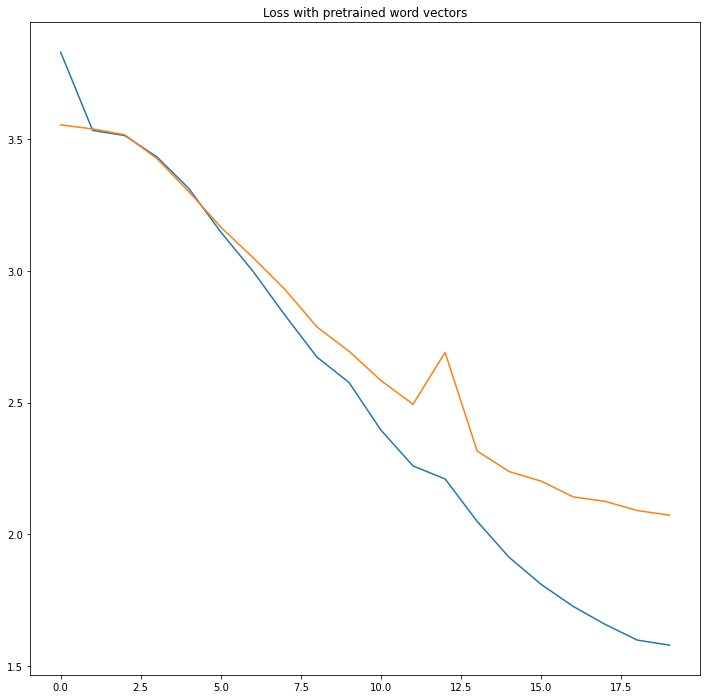

In [29]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12))
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Loss with pretrained word vectors")
plt.show()

--------------------------------------------------------------------------------------------------------------

## TESTING SENTENCES

### Cleaning the sentence

In [34]:
test_sentence= "python: Unpacking a list of dictionaries in cell to columns"

test_sentence = clean_text(test_sentence) 
test_sentence = clean_punct(test_sentence) 
test_sentence = lemitizeWords(test_sentence) 
test_sentence = stopWordsRemove(test_sentence) 

test_sentence

'python unpack list dictionaries cell columns'

### Embeding the sentence

In [35]:
ts_1=[word_index.get(title) for title in test_sentence.split(" ")]

test_data = pad_sequences([ts_1], maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")

### Predicting the tag

In [36]:
y_test=model.predict([test_data])

tag_index=np.argmax(y_test, axis=None, out=None)

ques_tag=le.inverse_transform([tag_index])

print(ques_tag)

['python']


----------------------------------------

## IMPROVING THE MODEL

### Using non frequent terms 

In [57]:
# Finding the most frequent words
tokens=[]

for j in range(len(new_df['Body'])):
        temp= tokenizer.tokenize(new_df['Body'].iloc[j])
        tokens.append(temp) 

tokens = [item for sublist in tokens for item in sublist]        

fd = FreqDist()

for word_token in tokens:
    fd.update([word_token])

    tag_freq=1


test_words=tokenizer.tokenize(test_sentence)




In [76]:
# Finding the least frequent word in the sentence

tag_freq_dict={}


for word_token in test_words:
    freq= fd.freq(word_token)
    tag_freq_dict.update({word_token: freq})



ques_tag_freq= nsmallest(2, tag_freq_dict, key = tag_freq_dict.get) 

    
ques_tags= set([ques_tag[0],ques_tag_freq[0],ques_tag_freq[1]])

In [77]:
print("Possible tags for the question are:", ques_tags)

Possible tags for the question are: {'python', 'unpack', 'dictionaries'}


----------------------------------------

## Next steps

- Deploy the model on flask (WIP)
- Improve model architecture
- Run the same model on question "Body"